# Modeling

## Overview
This notebook demonstrates the steps involved in training an image classification model using convolutional neural networks (CNNs) on Google Colab. We will go through data loading, preprocessing, model training, and evaluation.

### Steps Covered:
- Part 1: Loading and Normalizing Images
- Part 2: Defining and Training a Deep Learning Model with TensorFlow/Keras
- Part 3: (Optional) Distributed Training using TensorFlow’s Strategies
- Part 4: Saving Frequently Used Functions for Reusability


In [2]:
# Import libraries
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import io
from skimage.feature import hog
from tqdm import tqdm
from keras.utils import to_categorical
import cv2
import json

In [3]:
# Define global variables
IMAGE_SIZE = (150, 150)  # Define your desired image size
base_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision Toolbox/data/binaryclass/cats_dogs'
datasets = [os.path.join(base_path, 'train'), os.path.join(base_path, 'test')]
class_names = ['cats', 'dogs']  # Example class names
class_names_label = {name: i for i, name in enumerate(class_names)}

# Function to load images and labels for binary classification
def load_data(base_path, image_size=(150, 150)):
    """
    Load images from train and test directories, resize them, and return as training and testing datasets.
    This version is adapted for binary classification with labels in {0, 1}.

    Args:
        base_path (str): Path to the base directory containing 'train' and 'test' directories.
        image_size (tuple): Desired image size as (width, height).

    Returns:
        tuple: Tuple containing training and testing datasets:
               (images_train, labels_train, images_test, labels_test).
    """
    datasets = {'train': [], 'test': []}
    for phase in ['train', 'test']:
        data_path = os.path.join(base_path, phase)
        images = []
        labels = []
        print("Loading {} data...".format(phase))

        for folder in os.listdir(data_path):
            class_label = 1 if folder.lower() == 'dogs' else 0  # Assign 1 to 'dogs', 0 to 'cats'
            folder_path = os.path.join(data_path, folder)

            for file in tqdm(os.listdir(folder_path)):
                img_path = os.path.join(folder_path, file)
                image = cv2.imread(img_path)

                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, image_size)
                    image = image.astype(np.float32) / 255.0  # Normalize the images to [0, 1]

                    images.append(image)
                    labels.append(class_label)

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')

        datasets[phase].append(images)
        datasets[phase].append(labels)

    return datasets['train'][0], datasets['train'][1], datasets['test'][0], datasets['test'][1]

In [4]:
# Load the data
images_train, labels_train, images_test, labels_test = load_data(base_path)

Loading train data...


100%|██████████| 279/279 [00:20<00:00, 13.94it/s]


Loading test data...


100%|██████████| 70/70 [00:32<00:00,  2.17it/s]


In [14]:
# Model with regularization

def create_model(regularization_factor=0):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_factor), input_shape=(150, 150, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_factor)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_factor)),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Create and train model
model = create_model(0)
history = model.fit(images_train, labels_train, epochs=10, validation_data=(images_test, labels_test))

Epoch 1/10
18/18 [==============================] - 49s 3s/step - loss: 7.9408 - accuracy: 0.5458 - val_loss: 2.0208 - val_accuracy: 0.5214
Epoch 2/10
18/18 [==============================] - 45s 3s/step - loss: 0.8612 - accuracy: 0.6140 - val_loss: 1.1079 - val_accuracy: 0.5429
Epoch 3/10
18/18 [==============================] - 45s 3s/step - loss: 0.4435 - accuracy: 0.7882 - val_loss: 0.9523 - val_accuracy: 0.5786
Epoch 4/10
18/18 [==============================] - 45s 3s/step - loss: 0.2106 - accuracy: 0.9264 - val_loss: 0.8995 - val_accuracy: 0.5429
Epoch 5/10
18/18 [==============================] - 45s 3s/step - loss: 0.1121 - accuracy: 0.9820 - val_loss: 0.9322 - val_accuracy: 0.6643
Epoch 6/10
18/18 [==============================] - 47s 3s/step - loss: 0.0553 - accuracy: 0.9946 - val_loss: 0.9330 - val_accuracy: 0.5786
Epoch 7/10
18/18 [==============================] - 44s 2s/step - loss: 0.0308 - accuracy: 1.0000 - val_loss: 1.0759 - val_accuracy: 0.6571
Epoch 8/10
18/18 [==

In [ ]:
# Print the keys available in the history dictionary
print(history.history.keys())

# Access loss and accuracy for each epoch
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# You can print these values or plot them to visualize the trend
print("Training Loss: ", train_loss)
print("Training Accuracy: ", train_accuracy)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_accuracy)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Training Loss:  [7.940791606903076, 0.8611608147621155, 0.4434550404548645, 0.21058885753154755, 0.1120881736278534, 0.05525459721684456, 0.030837440863251686, 0.0158622395247221, 0.010285338386893272, 0.006778997834771872]
Training Accuracy:  [0.5457809567451477, 0.614003598690033, 0.7881507873535156, 0.9263913631439209, 0.9820466637611389, 0.9946140050888062, 1.0, 1.0, 1.0, 1.0]
Validation Loss:  [2.0208351612091064, 1.107889175415039, 0.9523453712463379, 0.8995184302330017, 0.9322237372398376, 0.9330242872238159, 1.075921654701233, 1.0349940061569214, 1.092825174331665, 1.139027714729309]
Validation Accuracy:  [0.5214285850524902, 0.5428571701049805, 0.5785714387893677, 0.5428571701049805, 0.6642857193946838, 0.5785714387893677, 0.6571428775787354, 0.6285714507102966, 0.6499999761581421, 0.6357142925262451]


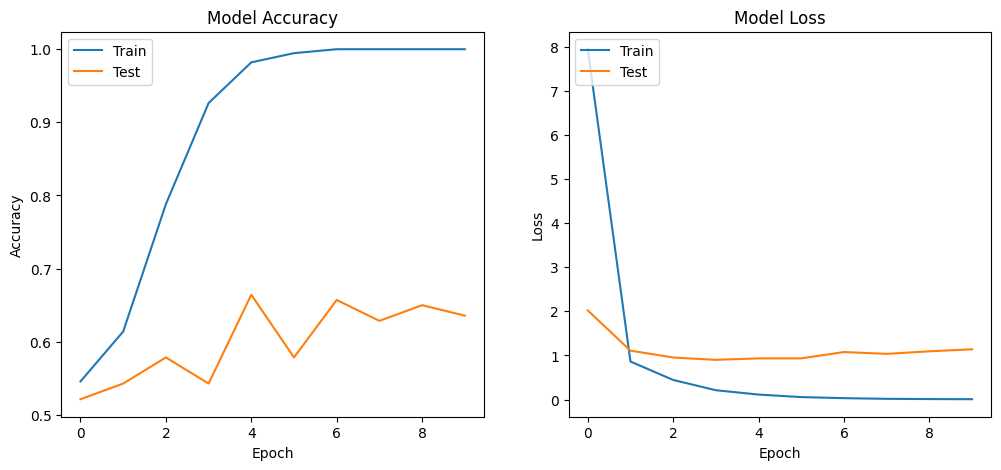

In [ ]:
# Plotting the metrics
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [ ]:
# Konvertujte history.history dictionary u JSON
history_json = json.dumps(history.history)

# Definišite putanju za čuvanje
path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision Toolbox/history1.json"

# Sačuvajte JSON podatke u fajl
with open(path, "w") as f:
    f.write(history_json)

It appears that model is overfitting, given the high training accuracy and the relatively poor and declining validation accuracy.

In [37]:
# Create a model with a different regularization factor
model2 = create_model(regularization_factor=0.01)

In [38]:
history2 = model2.fit(images_train, labels_train, epochs=10, validation_data=(images_test, labels_test))

Epoch 1/10
18/18 [==============================] - 38s 2s/step - loss: 5.7360 - accuracy: 0.4794 - val_loss: 2.8109 - val_accuracy: 0.5071
Epoch 2/10
18/18 [==============================] - 37s 2s/step - loss: 2.0989 - accuracy: 0.5512 - val_loss: 1.6022 - val_accuracy: 0.5000
Epoch 3/10
18/18 [==============================] - 34s 2s/step - loss: 1.3447 - accuracy: 0.5566 - val_loss: 1.1634 - val_accuracy: 0.5643
Epoch 4/10
18/18 [==============================] - 37s 2s/step - loss: 1.0699 - accuracy: 0.5853 - val_loss: 1.0061 - val_accuracy: 0.6214
Epoch 5/10
18/18 [==============================] - 35s 2s/step - loss: 0.9515 - accuracy: 0.6212 - val_loss: 0.9367 - val_accuracy: 0.5429
Epoch 6/10
18/18 [==============================] - 35s 2s/step - loss: 0.8924 - accuracy: 0.6517 - val_loss: 0.9057 - val_accuracy: 0.5929
Epoch 7/10
18/18 [==============================] - 37s 2s/step - loss: 0.8724 - accuracy: 0.6427 - val_loss: 0.8887 - val_accuracy: 0.5786
Epoch 8/10
18/18 [==

In [39]:
# Print the keys available in the history dictionary
print(history2.history.keys())

# Access loss and accuracy for each epoch
train_loss = history2.history['loss']
train_accuracy = history2.history['accuracy']
val_loss = history2.history['val_loss']
val_accuracy = history2.history['val_accuracy']

# You can print these values or plot them to visualize the trend
print("Training Loss: ", train_loss)
print("Training Accuracy: ", train_accuracy)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_accuracy)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Training Loss:  [5.736047267913818, 2.09893536567688, 1.3446886539459229, 1.0699412822723389, 0.951545000076294, 0.8923957347869873, 0.8724430799484253, 0.8738371729850769, 0.8538307547569275, 0.8190687298774719]
Training Accuracy:  [0.479353666305542, 0.5511669516563416, 0.5565529465675354, 0.5852782726287842, 0.6211849451065063, 0.6517055630683899, 0.6427289247512817, 0.6660681962966919, 0.6929982304573059, 0.7073608636856079]
Validation Loss:  [2.810887336730957, 1.6021709442138672, 1.1633615493774414, 1.0060665607452393, 0.9366708993911743, 0.9056500196456909, 0.8887014985084534, 0.89167720079422, 0.8675529956817627, 0.8827500343322754]
Validation Accuracy:  [0.5071428418159485, 0.5, 0.5642856955528259, 0.6214285492897034, 0.5428571701049805, 0.5928571224212646, 0.5785714387893677, 0.6000000238418579, 0.6071428656578064, 0.6357142925262451]


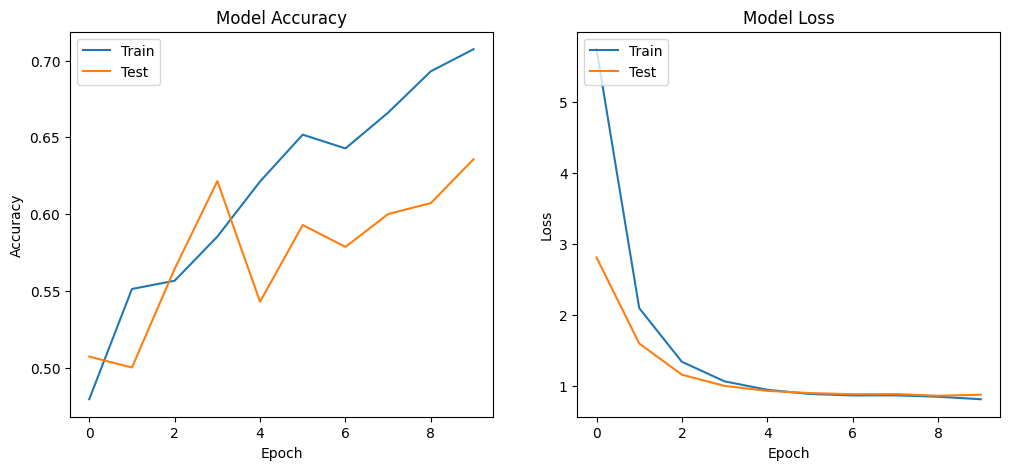

In [40]:
# Plotting the metrics
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [41]:
history_json = json.dumps(history2.history)

# Definišite putanju za čuvanje
path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision Toolbox/history2.json"

# Sačuvajte JSON podatke u fajl
with open(path, "w") as f:
    f.write(history_json)

In [11]:
def augment_image(img_data):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    img_data = img_data.reshape((1,) + img_data.shape)  # Reshape to (1, height, width, channels)
    it = datagen.flow(img_data, batch_size=1)
    augmented_image = it.next()[0].astype('uint8')  # Retrieve augmented image and ensure data type
    return augmented_image

In [12]:
import numpy as np

# Assuming images_train and labels_train are loaded and have correct shapes
augmented_images = []
augmented_labels = []

# Number of augmented copies to create for each image
num_augmented_per_image = 3

# Loop over all images and labels in the training set
for img, label in zip(images_train, labels_train):
    for _ in range(num_augmented_per_image):
        # Augment the image using your function
        aug_img = augment_image(img)
        augmented_images.append(aug_img)
        augmented_labels.append(label)  # Same label as the original image

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate the original and augmented datasets
final_train = np.concatenate((images_train, augmented_images))
final_labels = np.concatenate((labels_train, augmented_labels))


In [19]:
model3 = create_model(0)

In [20]:
history3 = model3.fit(final_train, final_labels, epochs=5, validation_data=(images_test, labels_test))

Epoch 1/5
70/70 [==============================] - 128s 2s/step - loss: 0.7815 - accuracy: 0.5072 - val_loss: 0.6923 - val_accuracy: 0.5214
Epoch 2/5
70/70 [==============================] - 135s 2s/step - loss: 0.6648 - accuracy: 0.5947 - val_loss: 0.6891 - val_accuracy: 0.5714
Epoch 3/5
70/70 [==============================] - 127s 2s/step - loss: 0.5748 - accuracy: 0.6495 - val_loss: 0.7022 - val_accuracy: 0.5214
Epoch 4/5
70/70 [==============================] - 129s 2s/step - loss: 0.4854 - accuracy: 0.7145 - val_loss: 0.8131 - val_accuracy: 0.5286
Epoch 5/5
70/70 [==============================] - 132s 2s/step - loss: 0.3966 - accuracy: 0.7644 - val_loss: 1.0493 - val_accuracy: 0.5786


In [21]:
# Print the keys available in the history dictionary
print(history3.history.keys())

# Access loss and accuracy for each epoch
train_loss = history3.history['loss']
train_accuracy = history3.history['accuracy']
val_loss = history3.history['val_loss']
val_accuracy = history3.history['val_accuracy']

# You can print these values or plot them to visualize the trend
print("Training Loss: ", train_loss)
print("Training Accuracy: ", train_accuracy)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_accuracy)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Training Loss:  [0.7815362215042114, 0.6648346185684204, 0.574847936630249, 0.48535704612731934, 0.3966009318828583]
Training Accuracy:  [0.5071813464164734, 0.5947037935256958, 0.6494613885879517, 0.7145422101020813, 0.764362633228302]
Validation Loss:  [0.6923303604125977, 0.6890616416931152, 0.7022424340248108, 0.8131030797958374, 1.04933500289917]
Validation Accuracy:  [0.5214285850524902, 0.5714285969734192, 0.5214285850524902, 0.5285714268684387, 0.5785714387893677]


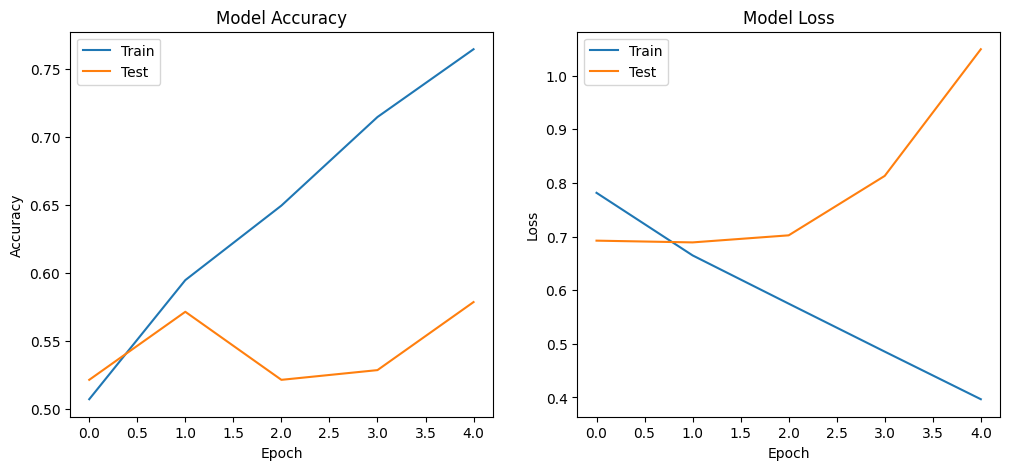

In [22]:
# Plotting the metrics
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [61]:
history_json = json.dumps(history3.history)

# Definišite putanju za čuvanje
path = "/content/drive/MyDrive/Colab Notebooks/Computer Vision Toolbox/history3.json"

# Sačuvajte JSON podatke u fajl
with open(path, "w") as f:
    f.write(history_json)

In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_model(
    input_shape,
    num_conv_layers=4,
    num_filters=32,
    dropout_rate=0.3,
    activation='relu',
    learning_rate=0.0001,
    filter_size=(3, 3),
    optimizer=Adam,
    use_early_stop=False
):
    """
    Creates a convolutional neural network model according to the specified parameters.

    Parameters:
    - input_shape (tuple): Shape of the input images.
    - num_conv_layers (int): Number of convolutional layers.
    - num_filters (int): Number of filters in the first convolutional layer.
    - dropout_rate (float): Dropout rate.
    - activation (str): Activation function for the convolutional layers and the dense layer.
    - learning_rate (float): Learning rate for the optimizer.
    - filter_size (tuple): Size of the filters for the convolutional layers.
    - optimizer (class): Optimizer class to be used.
    - use_early_stop (bool): Flag to determine whether to use early stopping.

    Returns:
    - model (tf.keras.Model): Compiled convolutional neural network model.
    - callbacks_list (list): List of callbacks to use during training.
    """
    model = Sequential()
    model.add(Conv2D(num_filters, filter_size, activation=activation, input_shape=input_shape))

    for _ in range(1, num_conv_layers):
        num_filters *= 2
        model.add(Conv2D(num_filters, filter_size, activation=activation))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation=activation))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    callbacks_list = []
    if use_early_stop:
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
        callbacks_list.append(early_stop)

    return model, callbacks_list


In [16]:
# Example usage
input_shape = (150, 150, 3)  # Assuming all images are reshaped to this dimension before being passed
model4, callbacks = create_model(input_shape=input_shape, use_early_stop=True)

# Now fit the model outside the function
from time import time
start = time()
history4 = model4.fit(images_train, labels_train, epochs=10,
                    validation_data=(images_test, labels_test),
                    callbacks=callbacks)
print(f'Duration of training: {time() - start}')

Epoch 1/10
18/18 [==============================] - 114s 6s/step - loss: 0.7073 - accuracy: 0.4973 - val_loss: 0.6911 - val_accuracy: 0.5214
Epoch 2/10
18/18 [==============================] - 118s 7s/step - loss: 0.6863 - accuracy: 0.5206 - val_loss: 0.6887 - val_accuracy: 0.5714
Epoch 3/10
18/18 [==============================] - 109s 6s/step - loss: 0.6725 - accuracy: 0.5853 - val_loss: 0.6854 - val_accuracy: 0.5857
Epoch 4/10
18/18 [==============================] - 113s 6s/step - loss: 0.6536 - accuracy: 0.6212 - val_loss: 0.6873 - val_accuracy: 0.6000
Epoch 5/10
18/18 [==============================] - 113s 6s/step - loss: 0.6072 - accuracy: 0.6571 - val_loss: 0.6928 - val_accuracy: 0.6143
Epoch 6/10
18/18 [==============================] - 113s 6s/step - loss: 0.5675 - accuracy: 0.7217 - val_loss: 0.6862 - val_accuracy: 0.6714
Epoch 7/10
18/18 [==============================] - 113s 6s/step - loss: 0.5269 - accuracy: 0.7469 - val_loss: 0.6783 - val_accuracy: 0.6071
Epoch 8/10
18

In [17]:
# Print the keys available in the history dictionary
print(history4.history.keys())

# Access loss and accuracy for each epoch
train_loss = history4.history['loss']
train_accuracy = history4.history['accuracy']
val_loss = history4.history['val_loss']
val_accuracy = history4.history['val_accuracy']

# You can print these values or plot them to visualize the trend
print("Training Loss: ", train_loss)
print("Training Accuracy: ", train_accuracy)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_accuracy)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Training Loss:  [0.7072919607162476, 0.6863170862197876, 0.6725204586982727, 0.6535879969596863, 0.6072361469268799, 0.5674805045127869, 0.526901364326477, 0.47841525077819824, 0.4347274899482727, 0.38351699709892273]
Training Accuracy:  [0.4973070025444031, 0.520646333694458, 0.5852782726287842, 0.6211849451065063, 0.6570915579795837, 0.7217234969139099, 0.7468581795692444, 0.7863554954528809, 0.8114901185035706, 0.8491920828819275]
Validation Loss:  [0.691051721572876, 0.6887080669403076, 0.6853852868080139, 0.6872658729553223, 0.6928373575210571, 0.686248779296875, 0.6782738566398621, 0.657348096370697, 0.6766221523284912, 0.7756147980690002]
Validation Accuracy:  [0.5214285850524902, 0.5714285969734192, 0.5857142806053162, 0.6000000238418579, 0.6142857074737549, 0.6714285612106323, 0.6071428656578064, 0.6714285612106323, 0.6571428775787354, 0.5714285969734192]


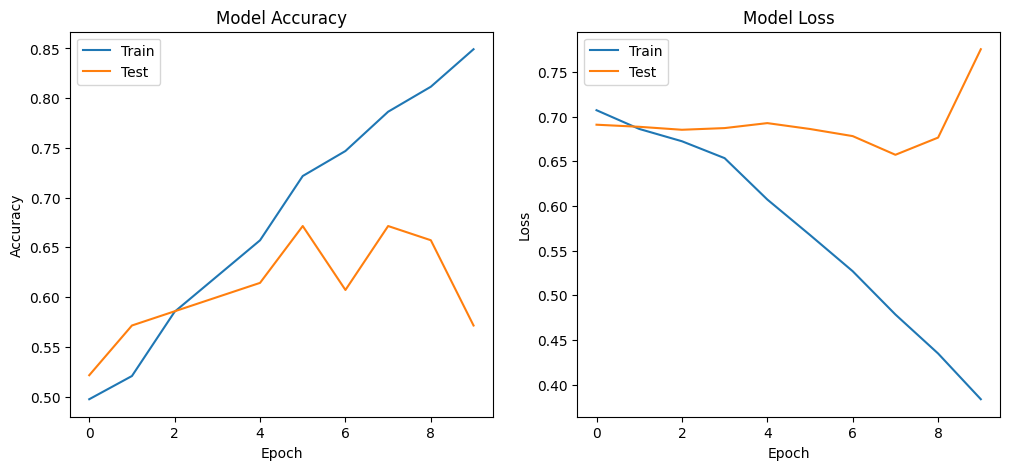

In [18]:
# Plotting the metrics
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [19]:
# Example usage
input_shape = (150, 150, 3)  # Assuming all images are reshaped to this dimension before being passed
model5, callbacks = create_model(input_shape=input_shape, use_early_stop=True)

# Now fit the model outside the function
from time import time
start = time()
history5 = model5.fit(final_train, final_labels, epochs=5,
                    validation_data=(images_test, labels_test),
                    callbacks=callbacks)
print(f'Duration of training: {time() - start}')

Epoch 1/5
70/70 [==============================] - 422s 6s/step - loss: 0.6952 - accuracy: 0.4973 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 2/5
70/70 [==============================] - 417s 6s/step - loss: 0.6881 - accuracy: 0.5444 - val_loss: 0.6905 - val_accuracy: 0.5143
Epoch 3/5
70/70 [==============================] - 416s 6s/step - loss: 0.6718 - accuracy: 0.5660 - val_loss: 0.6842 - val_accuracy: 0.5143
Epoch 4/5
70/70 [==============================] - 420s 6s/step - loss: 0.6338 - accuracy: 0.6216 - val_loss: 0.6596 - val_accuracy: 0.6357
Epoch 5/5
70/70 [==============================] - 419s 6s/step - loss: 0.5924 - accuracy: 0.6468 - val_loss: 0.6395 - val_accuracy: 0.6286
Duration of training: 2125.042197704315
